### Analyzing the CAPM
Summary Statistics. For each portfolio, calculate both the Sharpe Ratio and Treynor Ratio.

(a) Make a plot with the SR of each asset on the horizontal axis, and the TR on the vertical
axis.

(b) What do you observe? What would the CAPM predict about this plot?

(c) From these measures, which portfolios look attractive? Which look unattractive?

### CAPM Formula - The most famous Linear Factor Model
$ E\left[\tilde{r^i}\right] = \beta^{i,m}E\left[\tilde{r^m}\right] $

* That is to say CAPM believes that, 单个portfolio带来的returns等于整个市场portfolio（ a broad equity index）带来的returns乘上一个beta值
* Beta is equal to $\beta^{i,m} = \frac{cov(\tilde{r^i},\tilde{r^m})}{var(tilde{r^m})}$

In [9]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display
sns.set_style("darkgrid")
sns.set()

path = 'ff_data.xlsx'
factors_df = pd.read_excel(path,sheet_name='FACTORS',index_col='date')[['MKT']]

portfolios_df = pd.read_excel(path, sheet_name='PORTFOLIOS', index_col='date')

# now to join them together
df_analysis = portfolios_df.join(factors_df) # the DataFrame with 25 portfolios and a market data

In [51]:
'''
Here is an example using OLS regressions
'''

bm_portfolios = pd.DataFrame(index=portfolios_df.columns) # here we get the list of all portfolio names as the index
rhs = sm.add_constant(df_analysis['MKT']) # sm.add_const() 是添加自变量 factor 的方法
ave_market_ret = df_analysis['MKT'].mean()
std_market_ret = df_analysis['MKT'].std()

bm_residuals = pd.DataFrame(columns=portfolios_df.columns)
t_p_values = pd.DataFrame()

for portf in bm_portfolios.index: # for each portfolio 逐行（逐个portfolio）进行列的填充
    lhs = df_analysis[portf] # the historical return data for each portfolio
    res = sm.OLS(lhs, rhs, missing='drop').fit() # will do the regression of each portfolio returns against market return and constants
    bm_portfolios.loc[portf, 'alpha_hat'] = res.params['const'] # for each portfolio, compute the alpha (the const parameter in the regression result)
    bm_portfolios.loc[portf, 'beta_hat'] = res.params['MKT'] # for each portfolio, compute the beta (the regression on factors in the regression result)
    bm_portfolios.loc[portf, 'r_squared'] = res.rsquared
    bm_portfolios.loc[portf, 'CAPM_implied_excess_ret'] = ave_market_ret * bm_portfolios.loc[portf, 'beta_hat'] # pure CAPM
    bm_portfolios.loc[portf, 'ave_excess_ret'] = df_analysis[portf].mean()
    bm_portfolios.loc[portf, 'std_excess_ret'] = df_analysis[portf].std()
    bm_residuals[portf] = res.resid # for each portfolio, fill in with the residual

    t_p_values.loc[portf, 't-value'] = res.params['const']
    t_p_values.loc[portf, 't-value'] = res.tvalues['const']
    t_p_values.loc[portf, 'p-value'] = round(res.pvalues['const'], 4)

# 在 bm_portfolis 每一行的portfolio，创建列并赋值
bm_portfolios['sharpe_ratio'] = np.sqrt(12) * bm_portfolios['ave_excess_ret'] / bm_portfolios['std_excess_ret']
bm_portfolios['treynor_ratio'] = 12 * bm_portfolios['ave_excess_ret'] / bm_portfolios['beta_hat']
bm_portfolios['portfolio'] = bm_portfolios.index.values #str.split('portfolio').str[1].astype(int)
bm_portfolios['portfolio_num'] = np.arange(1,len(bm_portfolios.index.values)+1) #str.split('portfolio').str[1].astype(int)
# the last column, portfolio_num is just to number each portfolio from 1 to 25

c:\users\zhiwei hu\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


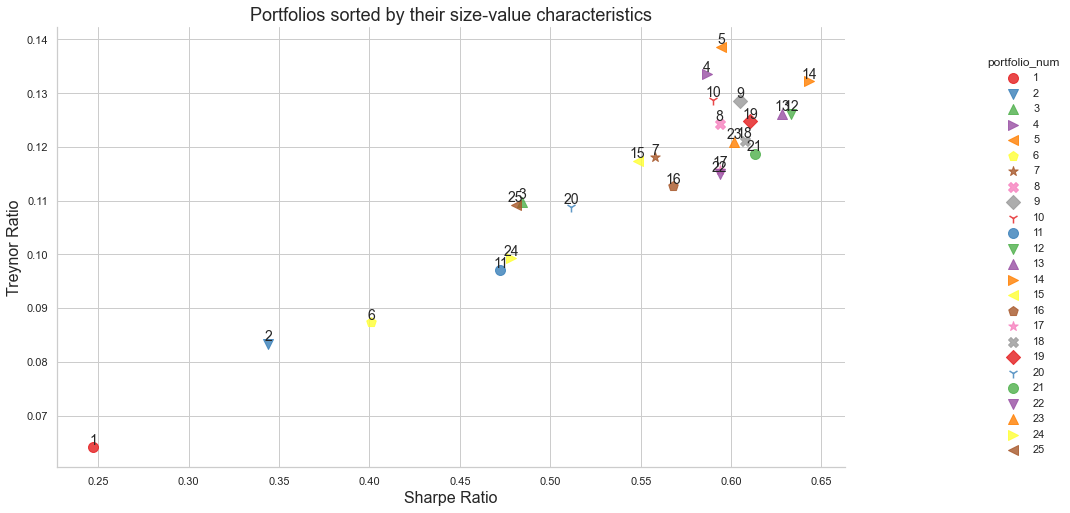

In [19]:
markers=['o', 'v', '^', '>', '<', 'p', '*', 'X', 'D', '1','o',\
         'v', '^', '>', '<', 'p', '*', 'X', 'D', '1','o', 'v', '^', '>', '<']
sns.set_style("whitegrid")
ax = sns.lmplot('sharpe_ratio', # Horizontal axis
               'treynor_ratio', # Vertical axis
               hue='portfolio_num',palette="Set1",scatter_kws={"s": 100},
                data=bm_portfolios, # Data source
               fit_reg=False, # Don't fix a regression line
               markers=markers,
               aspect =1) # size and dimension
ax.fig.set_figwidth(16)
ax.fig.set_figheight(7)
plt.title('Portfolios sorted by their size-value characteristics', fontsize=18)
plt.xlabel('Sharpe Ratio', fontsize=16)
plt.ylabel('Treynor Ratio', fontsize=16)

# 以下这个函数仅仅是为了给图中的每个点标号 from 1 ~ 25
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(int(point['val'])), fontsize=14,\
                horizontalalignment='center', verticalalignment='bottom')

label_point(bm_portfolios.sharpe_ratio, bm_portfolios.treynor_ratio, bm_portfolios.portfolio_num, plt.gca())

***2. For each of the n = 25 test portfolios, run the CAPM time-series regression from the lecture:***
<br><br>
$$ \tilde{r_t^i} = \alpha^i + \beta^{i,m}\tilde{r_t^m} + \epsilon_t^i $$

So you are running 25 separate regressions, each using the $T$-sized sample of time-series data.

   (a) Use the estimated $\beta$ as well as the historic average of $\tilde{r^m}$ to calculate $E\left[\tilde{r^i}\right]$ as implied by
the CAPM.

   (b) Plot this along the horizontal axis with the actual historic mean return of $\tilde{r^i}$ on the vertical axis.


c:\users\zhiwei hu\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


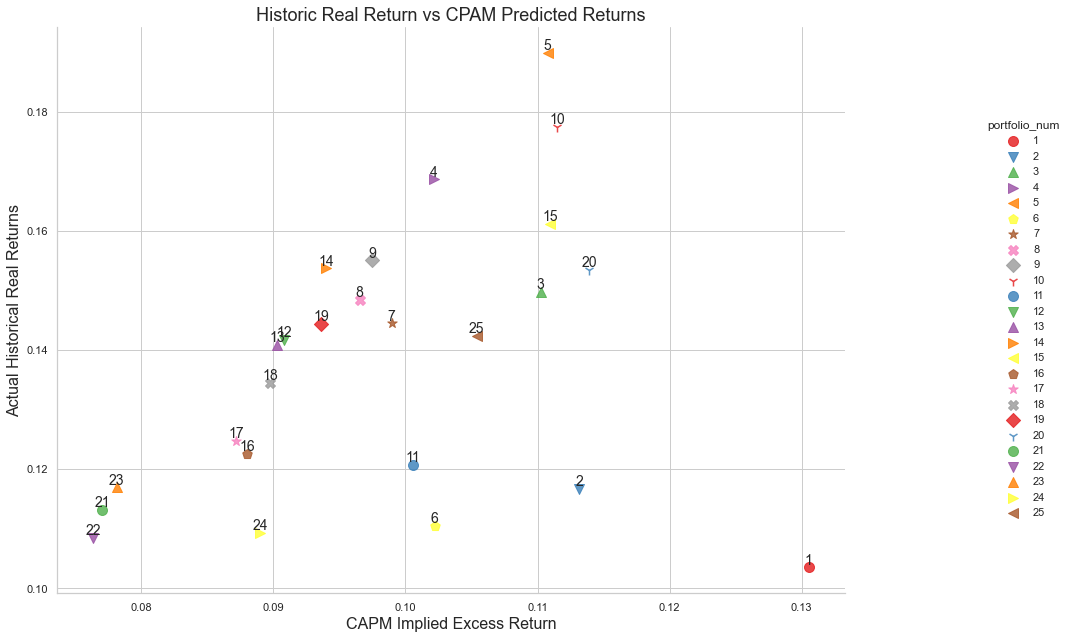

In [22]:
# to calculate the expected returns of 25 portfolios using the CAPM, use beta*MKT_returns
bm_portfolios.beta_hat*df_analysis['MKT'].mean() # this is the expected value

# now to plot to compare the historical value and the expected returns using CAPM
bm_portfolios['CPAM_implied_execessive_returns_annual'] = 12 * bm_portfolios['CAPM_implied_excess_ret'] # the CAPM predicted values
bm_portfolios['Historical_execissive_return_annual'] = 12 * bm_portfolios['ave_excess_ret'] # the real historic values

# now we plot them
sns.set_style('whitegrid')
ax = sns.lmplot('CPAM_implied_execessive_returns_annual', # Horizontal axis, the column name
                'Historical_execissive_return_annual', # Vertical axis, the column name
                hue = 'portfolio_num', palette='Set1', scatter_kws={'s':100},
                data=bm_portfolios, # the datasource, where to find the column name
                fit_reg= False,
                markers=markers, # 沿用上面设定好的markers
                aspect=1) # for size and dimension

ax.fig.set_figheight(9)
ax.fig.set_figwidth(16)
# 用sns这个api画好图之后，还需要用matplotlib加上一些其他的部件
plt.title('Historic Real Return vs CPAM Predicted Returns', fontsize = 18)
plt.xlabel('CAPM Implied Excess Return', fontsize = 16)
plt.ylabel('Actual Historical Real Returns', fontsize = 16)

# now to add the label points, add the fonts on each scatter
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(int(point['val'])), fontsize=14,\
                horizontalalignment='center', verticalalignment='bottom')

label_point(bm_portfolios['CPAM_implied_execessive_returns_annual'],\
            bm_portfolios['Historical_execissive_return_annual'], bm_portfolios.portfolio_num, plt.gca())

### Model How Well The Model Performs

(a) Report the mean-absolute-error of the CAPM:

   $$ MAE = \frac{1}{n} \sum_{i=1}^n |\alpha_i| $$

   (b) Under classic statistical assumptions, we can test the null hypothesis that the CAPM works
by calculating,

$$ H = T\left[1+({SR}_m)^2\right]^{-1} \boldsymbol{\alpha^{'}} \Sigma_{\epsilon}^{-1} \boldsymbol{\alpha} $$

$$ H \sim \chi_n^2 $$

Note the following:
- $\boldsymbol{\alpha}$ is an $n \times 1$ vector of the individual regression alphas,$\alpha_i$.
- $\Sigma$ is the $n \times n$ covariance matrix of the time-series of regression residuals, $\epsilon^i$, corresponding to each regression.
- ${SR}_m$ is the Sharpe-Ratio of $\tilde{r^m}$.

The test statistic, $H$, has a chi-squared distribution with $n = 25$ degrees of freedom. So
under the null hypothesis of the CAPM holding, $H$ should be small, and the distribution
allows us to calculate the probability of seeing such a large $H$, conditional on the CAPM
being true.

   (c) Which is a stricter test: checking whether any of the n values of $\alpha^i$ have a statistically
significant t-test or checking whether $H$ calculated above is significant?

   (d) Conceptually, how does the test-statistic $H$ relate to checking whether $\tilde{r^m}$ spans the tangency portfolio?

In [26]:
# to collect the alpha hat, that is the constants
mae = (bm_portfolios['alpha_hat']*12*100).abs().mean() # to annualize it?
print('MAE = {:.2f} %'.format(mae))

MAE = 4.19 %


In [41]:
# to test the null-hypothesis
T = df_analysis.dropna().shape[0] # T = 样本行数, shape[0] is the number of rows, while shape[1] is the number of columns
SR = ave_market_ret / std_market_ret
Sigma = bm_residuals.cov()
Sigma_inv = pd.DataFrame(np.linalg.inv(Sigma), index=Sigma.index, columns=Sigma.columns)
# 直接inverse会损失掉index和列的名称，因此这里需要重建一个dataframe并且将index和columns重新传进去
alpha = bm_portfolios['alpha_hat']
H = T * (1 + SR**2)**(-1) * alpha @ Sigma_inv @ alpha
print(H)
pvalue = 1-scipy.stats.chi2.cdf(H,df=25)
print(pvalue)

465.43995260643715
0.0


In [42]:
display(t_p_values.sort_values(by='p-value',ascending=False)) # t-p-values 是上文新建填充的一个DataFrame，用于存放每一个PORTFOLIO的t/p数据

,t-value,p-value
ME1 BM2,0.155829,0.8762
ME2 BM1,0.544050,0.5865
SMALL LoBM,-0.888451,0.3745
ME3 BM1,1.757838,0.0790
ME5 BM4,1.900318,0.0576
BIG HiBM,2.079426,0.0378
ME1 BM3,2.134119,0.0330
ME4 BM5,2.575967,0.0101
ME3 BM5,3.276238,0.0011
ME2 BM2,3.501206,0.0005


There's a huge error given by H, the test then rejects that CAPM holds, even at a critical value of 0.01%.
In our case, we may find that most of the alphas (20 alphas) are significant (as $p$-value $\leq$ 0.05) while 5 alphas are not signficant (as $p$-value $\geq$ 0.05) as judged by their individual $t$-stats, yet all of them are jointly significant as judged by this joint test.</span>



In [57]:
# to build a new OLS regression results between the average exessive returns and beta given by CAPM

bm_portfolios.columns
res = smf.ols(formula="ave_excess_ret ~ beta_hat", data=bm_portfolios).fit()
display(res.summary())
display(bm_portfolios)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ave_excess_ret   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     2.945
Date:                Wed, 04 Nov 2020   Prob (F-statistic):             0.0996
Time:                        14:14:06   Log-Likelihood:                 122.92
No. Observations:                  25   AIC:                            -241.8
Df Residuals:                      23   BIC:                            -239.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0066      0.003      2.327      0.029       0.001       0.013
beta_hat       0.0040      0.002      1.716      0.100      -0.001       0.009
==============================================================================
Omnibus:                        1.187   Durbin-Watson:                   1.324
Prob(Omnibus):                  0.552   Jarque-Bera (JB):                0.449
Skew:                          -0.315   Prob(JB):                        0.799
Kurtosis:                       3.189   Cond. No.                         15.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,alpha_hat,beta_hat,r_squared,CAPM_implied_excess_ret,ave_excess_ret,std_excess_ret,sharpe_ratio,treynor_ratio,portfolio,portfolio_num
SMALL LoBM,-0.002253,1.614316,0.510648,0.010877,0.008625,0.120835,0.247252,0.064111,SMALL LoBM,1
ME1 BM2,0.000295,1.399694,0.584778,0.009431,0.009726,0.097904,0.344135,0.083385,ME1 BM2,2
ME1 BM3,0.003290,1.363430,0.668217,0.009187,0.012477,0.089215,0.484450,0.109810,ME1 BM3,3
ME1 BM4,0.005541,1.263168,0.663103,0.008511,0.014052,0.082972,0.586684,0.133496,ME1 BM4,4
SMALL HiBM,0.006594,1.369878,0.631354,0.009230,0.015824,0.092217,0.594443,0.138621,SMALL HiBM,5
ME2 BM1,0.000682,1.264286,0.723417,0.008519,0.009201,0.079509,0.400887,0.087334,ME2 BM1,6
ME2 BM2,0.003792,1.223878,0.766744,0.008247,0.012039,0.074761,0.557820,0.118038,ME2 BM2,7
ME2 BM3,0.004323,1.193961,0.783205,0.008045,0.012368,0.072163,0.593692,0.124302,ME2 BM3,8
ME2 BM4,0.004794,1.205735,0.759834,0.008124,0.012919,0.073987,0.604851,0.128571,ME2 BM4,9
ME2 BM5,0.005500,1.378498,0.721300,0.009288,0.014789,0.086818,0.590079,0.128738,ME2 BM5,10


In [46]:
# a
lambda_M = res.params['beta_hat']
alpha_ = res.params['Intercept']

print('Lambda = {:.2f}%'.format(lambda_M*100))
print('Sample average = {:.2f}%'.format(12 * df_analysis['MKT'].mean()*100))
print('Average mispricing of the premia = intercept = {:.2f}%'.format(alpha_*12*100))

Lambda = 0.40%
Sample average = 8.09%
Average mispricing of the premia = intercept = 7.98%


In [48]:
# b
tilde_alpha = res.resid
MAE_tilde_alpha = (100 * 12 * tilde_alpha).abs().mean()
print("MAE alpha_tilde = {:.2f}%".format(MAE_tilde_alpha))
print("MAE alpha (previous section) = {:.2f}%".format(mae))

MAE alpha_tilde = 1.68%
MAE alpha (previous section) = 4.19%


In [49]:
# c
# to re-calculate the MAE
H = T * (1 + SR**2)**(-1) * tilde_alpha @ Sigma_inv @ tilde_alpha
print('H = {:.2f}'.format(H))
pvalue = 1 - scipy.stats.chi2.cdf(H, df=25)
print('p-value = {:.4f}'.format(pvalue))


H = 102.08
p-value = 0.0000
